In [13]:
# Allows to make changes to the classes without restarting the notebook 💀 # TODO: Delete once done
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [15]:
from continuous_model.Bee import BeeSwarm
from continuous_model.Hive import Hive
from continuous_model.Model import ForagerModel
from continuous_model.Resource import Resource
from continuous_model.config import *

In [16]:
model_config = ModelConfig(n_resource_sites=0)
hive_config = HiveConfig()
beeswarm_config = BeeSwarmConfig()
resource_config = ResourceConfig()

model = ForagerModel(model_config, hive_config, beeswarm_config, resource_config)
model.create_agent(Resource, location=(900, 900))

  0%|          | 0/100 [00:00<?, ?it/s]

Bee died by outside risk


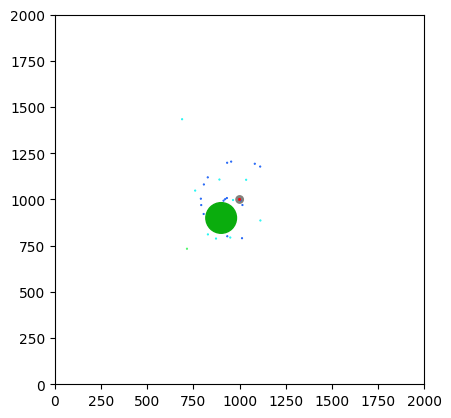

In [17]:
fig, ax = plt.subplots(1,1)

for _ in tqdm(range(1440)):
    model.step()

model.plot(ax)

plt.show()